### Example 2: Cell with lamellipodia

The cell surface is located in `../../../data/mesh/lamellipodia_cell.obj`. It was derived by applying marching cubes with pyacvd remeshing in u-Unwrap3D after segmentation using [u-Segment3D](https://github.com/DanuserLab/u-segment3D) using this [script](https://github.com/DanuserLab/u-segment3D/blob/master/tutorials/single_cells/segment_lamellipodia_3D.py).

#### 0. Read in the surface mesh

In [1]:
import unwrap3D.Mesh.meshtools as meshtools
import unwrap3D.Utility_Functions.file_io as fio # for common IO functions
import unwrap3D.Unzipping.unzip as uzip
import unwrap3D.Segmentation.segmentation as segmentation
import unwrap3D.Image_Functions.image as image_fn
import unwrap3D.Analysis_Functions.topography as topo_tools
import unwrap3D.Visualisation.colors as vol_colors
import os
from matplotlib import cm 
import scipy.io as spio
import numpy as np
import skimage.io as skio 
import pylab as plt 

"""
Specifying image file location and parsing its name. 
"""
meshfolder = '../../../data/mesh'
meshfile = os.path.join(meshfolder, 'lamellipodia_cell.obj')

basefname = os.path.split(meshfile)[-1].split('.obj')[0] # get the filename with extension

mesh_S = meshtools.read_mesh(meshfile,
                             keep_largest_only=True) # read only the largest if there is multiple separate objects in the mesh


"""
Create a master save folder
"""
savefolder = os.path.join('example_results', 
                         basefname)
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Create subfolder within master save folder of the cell to store specifics of the input 
"""
savefolder_surf_S = os.path.join(savefolder,
                                 'Step0_input_surface_S')
fio.mkdir(savefolder_surf_S)


"""
We don't have the binary, therefore we voxelize the mesh to create one
"""
mesh_S_binary = meshtools.voxelize_image_mesh_pts(mesh_S, 
                                                  pad=25, 
                                                  dilate_ksize=2, 
                                                  erode_ksize=2, 
                                                  vol_shape=None)
mesh_S_binary = mesh_S_binary.transpose(2,1,0) # transpose so the binary is in the same format as the standard workflow

skio.imsave(os.path.join(savefolder_surf_S,
                         'mesh_S_binary.tif'),
                         np.uint8(255.*mesh_S_binary))


# measure the surface curvature from the binary
voxel_size = 0.160 #um

surf_H = meshtools.compute_mean_curvature_from_binary(mesh_S, 
                                                    mesh_S_binary.transpose(2,1,0), 
                                                    smooth_gradient=3, 
                                                    eps=1e-12,
                                                    invert_H=False,
                                                    return_H_img=False) # we just want the curvature
surf_H_colors = vol_colors.get_colors(surf_H/voxel_size, 
                                      colormap=cm.Spectral_r, 
                                      vmin=-1,
                                      vmax=1)

mesh_S.visual.vertex_colors = np.uint8(255.*surf_H_colors[...,:3])

tmp = mesh_S.export(os.path.join(savefolder_surf_S, 
                                 'input_mesh_S.obj'))

spio.savemat(os.path.join(savefolder_surf_S, 
                          'curvature_stats.mat'),
                          {'voxel_size':voxel_size,
                           'surf_H': surf_H, 
                           'surf_H_colors': surf_H_colors})


#### 1. run cMCF to get reference shape

We use a slower flow than the standard workflow example to catch better the transition.

In [2]:
savefolder_cMCF = os.path.join(savefolder,
                                 'Step1_cMCF_reference')
fio.mkdir(savefolder_cMCF)

Usteps_MCF_img, mesh_F, MCF_measures_dict = meshtools.conformalized_mean_curvature_flow(mesh_S, 
                                                                                    max_iter=50, 
                                                                                    rescale_output = True, # cMCF is solved in normalized coordinates, when True, the output will be rescaled to be in image coordinates.  
                                                                                    delta=1e-4, 
                                                                                    conformalize=True, # set this flag to run cMCF, else it will run MCF
                                                                                    robust_L =False, # if set, runs MCF/cMCF using the robust Laplacian instead of cotangent Laplacian
                                                                                    mollify_factor=1e-5, # this is a parameter used in the robust Laplacian
                                                                                    solver='pardiso')  # 'scipy': standard scipy solver, 'pardiso' for using Intel's pardiso solver to solve in parallel. 'pariso' is much faster. But you must use 'scipy' if you plan to multiprocess over different cells.

"""
Save the iterations
"""
# save the vertex positions with face connectivity
spio.savemat(os.path.join(savefolder_cMCF, 
                          'MCF_iterations_'+basefname+'.mat'), 
              {'v': Usteps_MCF_img, # rescaled image coordinates, since we ran with rescale_output=True(default)
               'f': mesh_F}) # face connectivity



100%|██████████| 50/50 [02:32<00:00,  3.04s/it]


possible iteration numbers for reference shape:
[ 6 27]
using the first as the reference. :
6


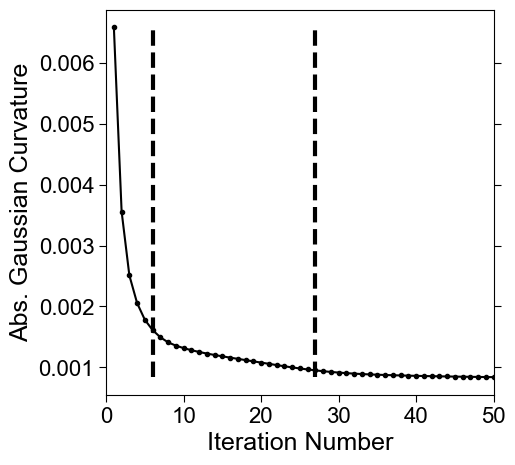

In [3]:

"""
Use discrete gaussian curvature to find first changepoint
"""
gauss_curve_MCF = MCF_measures_dict['gauss_curvature_iter'].copy()

inds = meshtools.find_all_curvature_cutoff_index(gauss_curve_MCF, 
                                                 avg_fnc=np.nanmean, # use moving means 
                                                 absval=True, # absolute value after subtracting baseline 
                                                 winsize=15, # window size for moving means, larger tends to slightly bias the found iteration number to later 
                                                 min_peak_height=1e-7, # minimum peak height
                                                 min_peak_distance=5) # minimal distance between detected peaks. 

print('possible iteration numbers for reference shape:')
print(inds)

if len(inds) > 0:
    ind = inds[0] 
else:
    ind = 0 

print('using the first as the reference. :')
print(ind)

"""
Construct the mesh at the found changepoint
"""
cMCF_mesh_S = mesh_S.copy(); cMCF_mesh_S.vertices = Usteps_MCF_img[...,ind].copy()

tmp = cMCF_mesh_S.export(os.path.join(savefolder_cMCF, 
                                      'cMCF_mesh_S.obj'))

MCF_measures_dict['ind'] = ind
MCF_measures_dict['inds'] = inds

# save the convergence measures. We computed several but found the mean absolute discrete Gaussian curvature (<|K|>) to best serve as a 'shape state' parameter
spio.savemat(os.path.join(savefolder_cMCF, 
                          'MCF_convergence_measures_'+basefname +'.mat'),
                           MCF_measures_dict) 


# make a plot and save in the folder
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.arange(1,len(gauss_curve_MCF)+1), 
          gauss_curve_MCF, '.-', color='k')
for ind in inds:
    plt.vlines(ind, 
                np.min(gauss_curve_MCF), 
                np.max(gauss_curve_MCF), 'k', linestyles='dashed', lw=3)
plt.tick_params(length=5, right=True)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.xlim([0,50])
plt.xlabel('Iteration Number', fontsize=18, fontname='Arial')
plt.ylabel('Abs. Gaussian Curvature', fontsize=18, fontname='Arial')
plt.savefig(os.path.join(savefolder_cMCF, 
                          'MCF_iterations_'+basefname.replace('.tif', '.svg')), bbox_inches='tight')
plt.show()


initial: -8
initial_watertight: -8


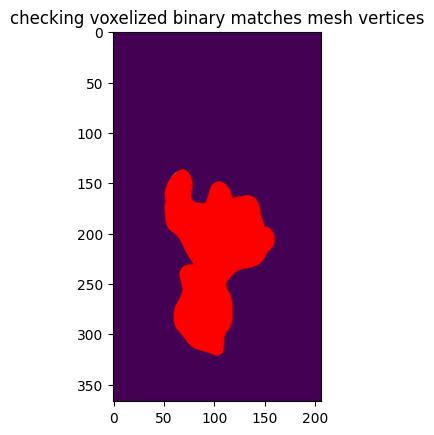

initiating a genus-0 mesh automatically with interval:  [4.089280543163545, 4.090029428233324]


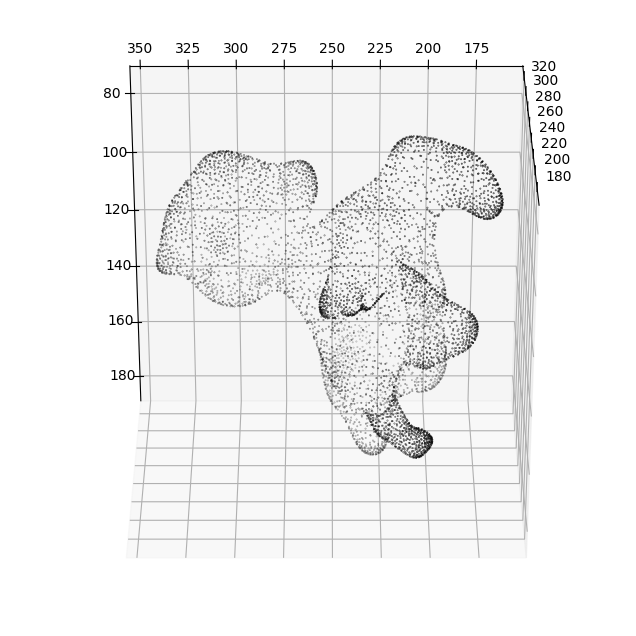

GVF iter: 15/15(85138, 3)


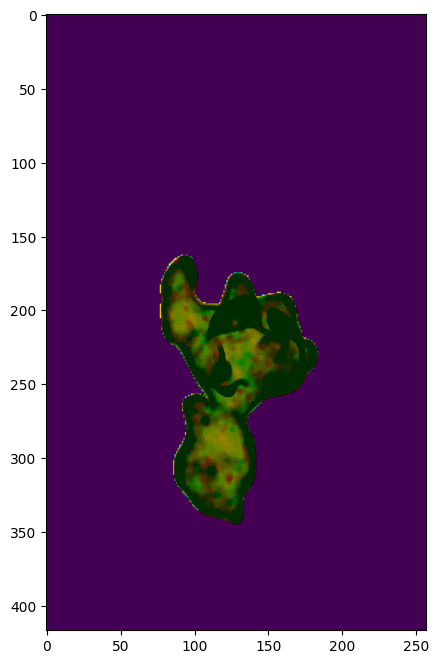

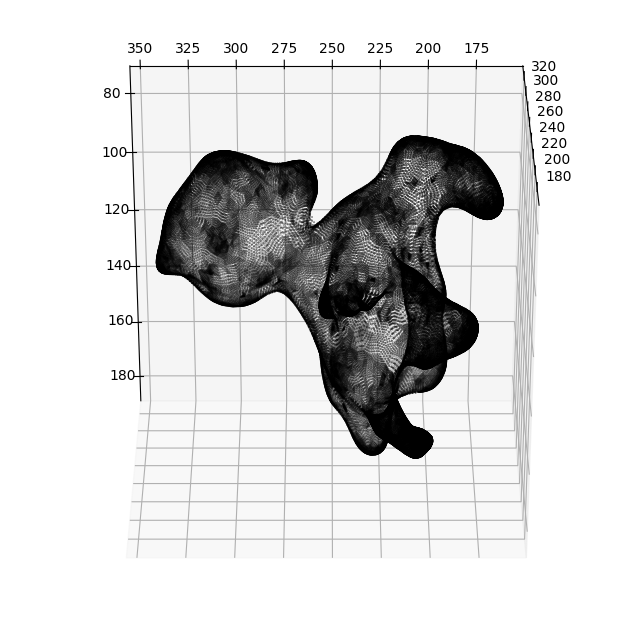

0
0 4.335801012102749 changing lr:  0.75
0 4.335801012102749
1
2
--------------------------
1 4.189334864607437
2
2
--------------------------
2 4.182354716177256
3
2
--------------------------
3 4.188637173505003 changing lr:  0.5625
3 4.188637173505003
4
2
--------------------------
4 3.9931816915839953
5
2
--------------------------
5 3.984538011784264
6
2
--------------------------
6 3.977406735551078
7
2
--------------------------
7 3.970494485626385
8
2
--------------------------
8 3.96413953213622
9
2
--------------------------
9 3.9765619674145904 changing lr:  0.421875
9 3.9765619674145904
{'convex': False, 'volume': True, 'watertight': True, 'orientability': True, 'euler_number': 2, 'genus': 0.0}


In [4]:

"""
check for genus-0, using Euler number (i.e. euler number == 2), if not satisfied run shrinkwrapping
"""
if cMCF_mesh_S.euler_number == 2: 
    # skip the shrinkwrapping and go to voxelization 
    genus0_cMCF_mesh = cMCF_mesh_S

else:
    """
    run shrinkwrapping to get genus-0 version 
    """
    total_shrinkwrap_iters = 100 # we can lower number when the shape is simple, as here, or let it be higher to see if we can get better wrap than initial
    decay_rate = 0.75
    min_lr = 0.24 # for decay_rate 0.5, this would mean lowest is 0.25.

    n_punchout_refinements = 0 # Set this >0 to run shrinkwrapping step 3 - step 2 loop n times for complex shapes with nasty concavities. Not needed here.

    # one round is largely sufficient for most cMCF Sref shapes as by definition they should have concavities largely removed. 
    mesh_shrinkwrap, mesh_watertight_in, mesh_genus0, iter_stats = meshtools.shrinkwrap_genus0_basic(cMCF_mesh_S, 
                                                                                                    use_GVF=True,
                                                                                                    GVF_mu=0.01, 
                                                                                                    GVF_iterations=15, 
                                                                                                    voxelize_padsize=50,
                                                                                                    voxelize_dilate_ksize = 3, # make dilate_ksize > erode_ksize if your mesh doesn't form a complete volume or there is quite a bit of holes.
                                                                                                    voxelize_erode_ksize = 2,  
                                                                                                    extra_pad=25,
                                                                                                    genus0_alpha_frac = 0.15, # default
                                                                                                    genus0_alpha_auto = True,
                                                                                                    genus0_tol = 1e-3, 
                                                                                                    total_shrinkwrap_iters = total_shrinkwrap_iters,
                                                                                                    decay_rate = decay_rate,  
                                                                                                    remesh_iters=10,
                                                                                                    conformalize=False, # use active contours - recommended 
                                                                                                    min_size=40e3, # minimum mesh vertices, increase might better cover smaller cavities but greatly increase computational time!
                                                                                                    upsample=1, 
                                                                                                    min_lr=min_lr, # minimum step_size dropping from 1.
                                                                                                    make_manifold = False, # run this. 
                                                                                                    watertight_fraction=0.1,
                                                                                                    deltaL=5e-4,
                                                                                                    alpha=0.1, # controls stiffness
                                                                                                    beta=0.5,# controls torsion
                                                                                                    solver='pardiso',
                                                                                                    curvature_weighting=False, 
                                                                                                    debugviz=True) # leave on if you want to see the state of the mesh, otherwise off. 
            
    # save out the output for visualization and checking 
    tmp=mesh_shrinkwrap.export(os.path.join(savefolder_cMCF, 
                                            'shrinkwrap_%s_cMCF-Sref.obj' %(basefname))) # this should be same as the last iteration mesh.
    tmp = mesh_watertight_in.export(os.path.join(savefolder_cMCF, 
                                'input_Sref_to_shrinkwrapping_%s.obj' %(basefname)))
    tmp = mesh_genus0.export(os.path.join(savefolder_cMCF, 
                                        'initial_genus0_shrinkwrap_Sref_%s.obj' %(basefname)))
    tmp = (iter_stats[2][-1]).export(os.path.join(savefolder_cMCF,
                                                'shrinkwrap_final-iter_%s_cMCF-Sref.obj' %(basefname)))


    # setup save variables ready for step 3 processing. [those stats will append to these]
    chamfer_dists = iter_stats[0]
    all_meshes_iter_genus0 = iter_stats[1] # this completes the euler number for each iteration - you can check this is 2.
    all_meshes_iter = iter_stats[2]
        
    # step 3 shrinkwrap code, executed only if n_punchout_refinements>0
    mesh_wrap = mesh_shrinkwrap.copy()

    # run this a few times. 
    for ii in np.arange(n_punchout_refinements): # use more iterations until happy 
        """
        1. detect nonconverged. 
        """
        mesh_wrap = meshtools.remove_nonshrinkwrap_triangles(mesh_wrap,
                                                            cMCF_mesh_S,
                                                            q_thresh=0.1,
                                                            max_dist_cutoff=1.25, # this controls the fidelity... 
                                                            sigma_dist_cutoff=2, 
                                                            sigma_area_cutoff=2, # this ? 
                                                            nearest_k=1,
                                                            dilate_voxels=3, # cut more away ? 
                                                            erode_voxels=1,
                                                            minsize=10)
        
        """
        2. re-prop surface. 
        """
        mesh_shrinkwrap, mesh_watertight_in, mesh_genus0, iter_stats = meshtools.attract_surface_mesh(mesh_in=mesh_wrap,
                                                                                                            mesh_ref=cMCF_mesh_S, 
                                                                                                            use_GVF=True, 
                                                                                                            GVF_mu=0.01, # this large, introduces noise 
                                                                                                            GVF_iterations=15,
                                                                                                        voxelize_padsize=50, # this is just leave enough padding space 
                                                                                                        voxelize_dilate_ksize = 2, 
                                                                                                        voxelize_erode_ksize = 2, ## was this cos of 3? 
                                                                                                        extra_pad=25,
                                                                                                        tightest_genus0_initial=True,
                                                                                                        genus0_alpha_frac = 0.1,
                                                                                                        genus0_alpha_auto = False,
                                                                                                        genus0_offset = 0.1,
                                                                                                        genus0_tol = 0.1, 
                                                                                                        total_shrinkwrap_iters = 100, # master number of iterations.
                                                                                                        decay_rate = 1., # no decay. 
                                                                                                        remesh_iters=10,
                                                                                                        conformalize=False, # use active contours
                                                                                                        min_size=80000, # minimum mesh vertices
                                                                                                        upsample=1, 
                                                                                                        min_lr=min_lr, # minimum step_size dropping from 1.
                                                                                                        make_manifold = False, # ah.. its prob this too. 
                                                                                                        watertight_fraction=0.1,
                                                                                                        deltaL=5e-4,
                                                                                                        alpha=0.1, # more stiff here and we can break through? 
                                                                                                        beta=0.5,# what if we reduce the bending? 
                                                                                                        solver='pardiso',
                                                                                                        curvature_weighting=False, 
                                                                                                        debugviz=True)
        
        all_meshes_iter.append(iter_stats[2])
        all_meshes_iter_genus0.append(iter_stats[1])
        chamfer_dists.append(iter_stats[0])

        """
        insert save if you want to check 
        """
        # here, i'm going to rewrite the previous final iteration shrinkwrap. checking how good this is, is a good general indicator if we need more refinement iterations i.e. increase the number of loops
        tmp = mesh_shrinkwrap.export(os.path.join(savefolder_cMCF,
                                                'shrinkwrap_final-iter_%s_cMCF-Sref.obj' %(basefname)))
        
        mesh_wrap = mesh_shrinkwrap.copy()


    # flatten all of it 
    if n_punchout_refinements>0:
        all_meshes_iter_flat = [x for all_meshes_iter_item in all_meshes_iter for x in all_meshes_iter_item]
        all_meshes_iter_genus0_flat = [x for all_meshes_iter_item in all_meshes_iter_genus0 for x in all_meshes_iter_item]
        all_chamfer_dists = np.hstack(chamfer_dists)
    else:
        all_meshes_iter_flat = all_meshes_iter
        all_meshes_iter_genus0_flat = all_meshes_iter_genus0
        all_chamfer_dists = chamfer_dists


    # we take the mesh with lowest chamfer distance to the input surface as the genus-0 $S_\text{ref}$
    final_mesh = all_meshes_iter_flat[np.argmin(all_chamfer_dists)]

    # we isotropically remesh this output to ensure good triangle quality [optional if running voxelization after]
    final_mesh = meshtools.incremental_isotropic_remesh(final_mesh)

    # save the final mesh
    tmp = final_mesh.export(os.path.join(savefolder_cMCF,
                                        'final_shrinkwrap_%s_cMCF_Sref.obj' %(basefname)))

    genus0_cMCF_mesh = final_mesh


"""
voxelize the reference to create a dilated version just in case there are thin necks etc that effect precision
"""
Sref_img_binary = meshtools.voxelize_image_mesh_pts(genus0_cMCF_mesh, # might be best here to use barycenter 
                                                    dilate_ksize=3, # this is the size of the ball kernel to plug holes and handles. 
                                                    erode_ksize=1, # make this smaller than erode_ksize to have it more dilated. 
                                                    vol_shape=mesh_S_binary.shape[::-1]) # If you know your image shape, specify the vol_shape for better speed, otherwise use None The ::-1, is because S(x,y,z) was extracted from a transposed version of the cell binary

"""
Re-extraction of surface mesh to obtain the final genus-0 $S_{\text{ref}(x,y,z)} for spherical parameterization 
"""
cMCF_Sref_remesh = meshtools.marching_cubes_mesh_binary(Sref_img_binary, 
                                                        presmooth=1., 
                                                        contourlevel=.5, 
                                                        remesh=True, 
                                                        remesh_method='CGAL', 
                                                        remesh_samples=0.25, # lower downsampling will give a coarser mesh, which is easier to get equiareal spherical parameterization but may lose accuracy in representing high-curvature protrusive features (if present).
                                                        predecimate=False, # only essential if remesh_method='pyacvd 
                                                        min_mesh_size=10000)  

# check this remesh gives a genus-0 mesh
mesh_property = meshtools.measure_props_trimesh(cMCF_Sref_remesh, main_component=True, clean=True) 
print(mesh_property)


In [5]:
# transfer the curvature from cMCF to the genus-0 cMCF

match_params, surf_H_Sref_remesh, _ = meshtools.transfer_mesh_measurements(cMCF_mesh_S, 
                                                                        cMCF_Sref_remesh.vertices,
                                                                        source_mesh_vertex_scalars=surf_H[:,None])
surf_H_Sref_remesh = surf_H_Sref_remesh[:,0]

surf_H_Sref_remesh_colors = vol_colors.get_colors(surf_H_Sref_remesh/voxel_size,
                                                  colormap=cm.Spectral_r,
                                                  vmin=-1, vmax=1)

cMCF_Sref_remesh.visual.vertex_colors = np.uint8(255.*surf_H_Sref_remesh_colors[...,:3])        

# save this mesh for unwrapping 
save_smooth_remesh_file = os.path.join(savefolder_cMCF, 
                                     'unwrap_cMCF_Sref_mesh.obj')
tmp = cMCF_Sref_remesh.export(save_smooth_remesh_file)

spio.savemat(os.path.join(savefolder_cMCF, 
                          'curvature_stats_genus0_Sref.mat'),
                          {'surf_H': surf_H,
                           'surf_H_remapped': surf_H_Sref_remesh})

#### 2. Conformal Spherical parameterization 

In [6]:
savefolder_conformal = os.path.join(savefolder,
                                    'Step2_conformal_sphere')
fio.mkdir(savefolder_conformal)

sphere_xyz_iterative, n_inverted_faces = meshtools.iterative_tutte_spherical_map(cMCF_Sref_remesh.vertices,
                                                                                 cMCF_Sref_remesh.faces, 
                                                                                deltaL = 5e-3, # like the cMCF, controls speed of convergence. 
                                                                                min_iter=5, # return as soon as iteration number > min_iter, and number of inverted faces is 0  
                                                                                max_iter=25, # run this many iterations to see if number of inverted reduces to 0
                                                                                mollify_factor=1e-5, 
                                                                                scale=1.) # gives just the vertices.

assert(n_inverted_faces[-1]==0)

conformal_sphere_mesh = cMCF_Sref_remesh.copy()
conformal_sphere_mesh.vertices = sphere_xyz_iterative

tmp = conformal_sphere_mesh.export(os.path.join(savefolder_conformal,
                                                'conformal_sphere_param_Sref_%s.obj' %(basefname)))


#### 3. Equiareal Spherical parameterization

 41%|████▏     | 207/500 [00:44<01:37,  3.01it/s]c:\Users\s205272\AppData\Local\miniconda3\envs\unwrap3d_test_py310_noskfmm\lib\site-packages\unwrap3D\Mesh\meshtools.py:4648: RuntimeWarning: All-NaN slice encountered
  max_size = igl.avg_edge_length(v, f) / np.nanmedian(gu_mag) # if divide by median less good.
100%|██████████| 500/500 [03:14<00:00,  2.58it/s]

distortion at found iteration number: 1.0016498473019195


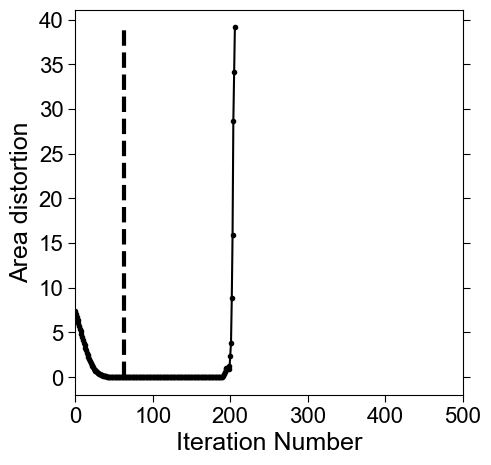

In [7]:
savefolder_equiareal = os.path.join(savefolder,
                                    'Step3_equiareal_sphere')
fio.mkdir(savefolder_equiareal)


# use a lot more iterations just in case. 
relax_v, relax_f, area_distortion_iter= meshtools.area_distortion_flow_relax_sphere(conformal_sphere_mesh, 
                                                                                    cMCF_Sref_remesh, 
                                                                                    max_iter=500, # this needs to be increased the more S_ref deviates from spherical. 
                                                                                    delta=0.1, # controls the stiffness, if too high - there is no flow, if too low - bijectivity is lost and flow may breakdown 
                                                                                    stepsize=1, 
                                                                                    debugviz=False) 

# compute the evolution of the mean area distortion. We use this to determine the first iteration when area distortion is minimized. 
area_distortion_iter_curve = np.hstack([np.mean(mm) for mm in area_distortion_iter])

# to determine when area distortion is minimised we look for the timepoint when the sign first changes. This is because once the minimum is reached, depending on stepsize, the mesh will start to oscilate. The larger the stepsize, the faster the convergence but the larger the oscillatory instability. 
min_area_distort = (np.arange(len(area_distortion_iter_curve))[:-1])[np.sign(np.diff(area_distortion_iter_curve))>0][0] # falls below 0. 

# check: print the area distortion value at min_area_distort. This should be close to 1 (the ideal minimum) for optimal relaxation.
print('distortion at found iteration number:', area_distortion_iter_curve[min_area_distort])


# the area_distortion_iter_curve is another great check of things are working, we plot the np.log(curve) to visualize a log scale.
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.arange(0,len(area_distortion_iter_curve)), np.log(area_distortion_iter_curve), '.-', color='k')
plt.vlines(min_area_distort, 
            np.nanmin(np.log(area_distortion_iter_curve)), 
            np.nanmax(np.log(area_distortion_iter_curve)), 'k', linestyles='dashed', lw=3)
plt.tick_params(length=5, right=True)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.xlim([0,len(area_distortion_iter_curve)])
plt.xlabel('Iteration Number', fontsize=18, fontname='Arial')
plt.ylabel('Area distortion', fontsize=18, fontname='Arial')
plt.savefig(os.path.join(savefolder_equiareal, 
                          'area-distortion_relax_iterations_'+basefname.replace('.tif', '.svg')), bbox_inches='tight')
plt.show()

# create the equiareal mesh and save it out
equiareal_sphere_mesh = conformal_sphere_mesh.copy()
equiareal_sphere_mesh.vertices = relax_v[min_area_distort].copy()

tmp = equiareal_sphere_mesh.export(os.path.join(savefolder_equiareal,
                                               'equiareal_sphere_param_Sref_%s.obj' %(basefname)))


#### 4. UV map

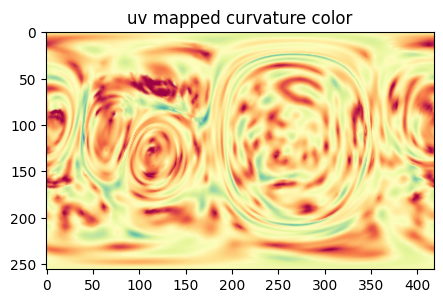

In [8]:
savefolder_uv = os.path.join(savefolder, 
                             'Step4_uv_map')
fio.mkdir(savefolder_uv)

"""
Optimize rotation for positive protrusions accounting for both Sref and S.
"""
curvature_cutoff_voxels = 0.01

# Compute mean curvature of S_ref 
H_Sref = meshtools.compute_mean_curvature(cMCF_Sref_remesh, radius=5)

# Threshold the above by cutoff together with that of the S
H_S = surf_H_Sref_remesh.copy()


binary_H_Sref = H_Sref > curvature_cutoff_voxels
binary_H_S = H_S > curvature_cutoff_voxels

# define weights as the absolute value of curvature
weighting_for_S = 0.5
weights = (1.-weighting_for_S)*binary_H_Sref+weighting_for_S*binary_H_S
weights_proj = weights.copy() # this is a signed i.e. has +/- values to resolve the ambiguity of putting the 

"""
Weighted Eigendecomposition to solve for the optimal rotation 
"""
rot_matrix, extra_rotate_bool = meshtools.optimize_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                weights=weights, 
                                                                                signed_weights_to_orient=weights_proj)

"""
Apply optimized rotation matrix to equiareal_sphere_mesh
"""
equiareal_sphere_mesh_rot_combined = meshtools.apply_optimized_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                    rot_matrix, 
                                                                                    extra_rotate_bool,
                                                                                    additional_rotation_angle_degrees=0)

"""
uv map and visualize curvature of S to check 
"""
# Perform the unwrap, and map the curvature color of S to check
# use length ratio aspect ratio optimization 
S_uv_opt, uv_Sref_equiareal_match_rot, h_opt, H_color, uv_surface_measurements_labels = uzip.uv_map_sphere_surface_parameterization(sphere_mesh=equiareal_sphere_mesh_rot_combined, 
                                                                                                                                    surface_mesh=cMCF_Sref_remesh,
                                                                                                                                    surface_measurements_scalars=cMCF_Sref_remesh.visual.vertex_colors[:,:3]*1., # make sure its float.
                                                                                                                                    surface_measurements_labels=None,
                                                                                                                                    uv_grid_size = 256, 
                                                                                                                                    optimize_aspect_ratio=True, # Set true if you want to optimize the number of columns  
                                                                                                                                    aspect_ratio_method='length_ratio', # method for optimizing aspect ratio.
                                                                                                                                    length_ratio_avg_fn=np.nanmedian,
                                                                                                                                    h_opt=None)
H_color = np.uint8(H_color) # convert back to uint8 for visualization

plt.figure(figsize=(5,5))
plt.title('uv mapped curvature color')
plt.imshow(H_color)
plt.show()

# save the parameters of the map
spio.savemat(os.path.join(savefolder_uv, 
                          'uv_mapping_params.mat'),
             {'uv_map' : S_uv_opt.astype(np.float32),
              'uv_mesh_match_tri_inds': uv_Sref_equiareal_match_rot[0],
              'uv_mesh_match_barycenter_weights': uv_Sref_equiareal_match_rot[1],
              'rot_matrix': rot_matrix, 
              'extra_rotate_bool': extra_rotate_bool,
              'equiareal_vertices': equiareal_sphere_mesh.vertices,
              'equiareal_faces': equiareal_sphere_mesh.faces,
              'weights' : weights,
              'weights_proj': weights_proj})


skio.imsave(os.path.join(savefolder_uv,
                         'uv_H_color.tif'),
                         H_color)

#### 5. Build Topography space

In [9]:
savefolder_topo = os.path.join(savefolder,
                               'Step5_topography_space')
fio.mkdir(savefolder_topo)

S_mesh_pts = mesh_S.vertices.copy()

topography_space, (N_in, N_out) = uzip.build_topography_space_from_Suv(S_uv_opt, 
                                                                        Sref_img_binary,
                                                                        external_gradient_field = None, # build if none, using Euclidean distance transform
                                                                        pad_size=50, 
                                                                        alpha_step=None, # use automatic method
                                                                        outer_surf_pts = S_mesh_pts,
                                                                        outer_n_dists = None, # let this be auto determined. 
                                                                        outer_pad_dist=10, # the leeway.
                                                                        outer_method='forward_euler',
                                                                        outer_smooth_win_factor=16, # we will smooth by minimum length of uv divide this factor. 
                                                                        inner_n_dists = 25, # in voxels.
                                                                        inner_sdf_method = 'harmonic',
                                                                        inner_source_mask = None, 
                                                                        inner_harmonic_ds = 4., # harmonic distance transform is memory-intensive and slow. Nearly always we must downsample so the volume is at most 256 x 256 x 256 voxels. 4x downsample by default. 
                                                                        inner_method='active_contours')

# check what is the dimensions of the topographic space
print('topographic space dimension: ', topography_space.shape)
print('the first %d slices are interior of S_ref' %(N_in))
print('the next %d slices are exterior of S_ref' %(N_out))

spio.savemat(os.path.join(savefolder_topo, 
                          'topographic_volume_space.mat'), 
             {'topographic_map': topography_space.astype(np.float32), 
              'uv_map': S_uv_opt, 
              'N_inside': N_in, 
              'N_outside': N_out}) 

100%|██████████| 36/36 [00:04<00:00,  8.35it/s]


laplacian 3D construction... 2.915717601776123


100%|██████████| 25/25 [00:07<00:00,  3.53it/s]


topographic space dimension:  (62, 256, 418, 3)
the first 36 slices are interior of S_ref
the next 25 slices are exterior of S_ref


#### 6. Extract topographic surface

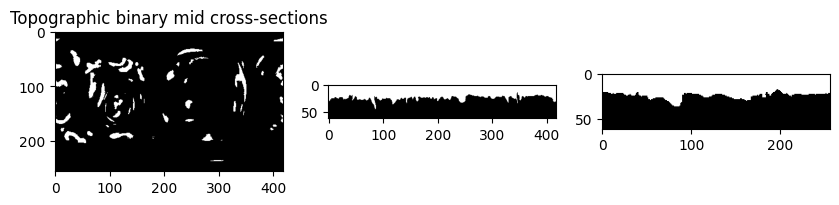

In [10]:
savefolder_topo_mesh = os.path.join(savefolder,
                                'Step6_topography_mesh')
fio.mkdir(savefolder_topo_mesh)

# map the cell binary
topographic_binary = image_fn.map_intensity_interp3(topography_space.reshape(-1,3)[...,::-1], 
                                                    grid_shape=mesh_S_binary.shape, 
                                                    I_ref=(mesh_S_binary>0)*255.) / 255. > 0.5
topographic_binary = topographic_binary.reshape(topography_space.shape[:-1])


# visualize the mid cross sections of topographic binary as check 
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.title('Topographic binary mid cross-sections')
plt.imshow(topographic_binary[topographic_binary.shape[0]//2,:,:], cmap='gray')
plt.subplot(132)
plt.imshow(topographic_binary[:,topographic_binary.shape[1]//2,:], cmap='gray')
plt.subplot(133)
plt.imshow(topographic_binary[:,:,topographic_binary.shape[2]//2], cmap='gray')
plt.show()


In [11]:


# we mesh and keep the largest connected component
topographic_mesh = meshtools.marching_cubes_mesh_binary(topographic_binary,   
                                                        presmooth=1., # applies a presmooth
                                                        contourlevel=.5, # isosurface level to mesh
                                                        keep_largest_only=True, # we want the largest connected component 
                                                        remesh=True,
                                                        remesh_method='CGAL', 
                                                        remesh_samples=.5, # remeshing with a target #vertices = 50% of original
                                                        predecimate=False, # must be True if using remesh_method='pyacvd'
                                                        min_mesh_size=10000,
                                                        upsamplemethod='inplane') # upsample the mesh if after the simplification and remeshing < min_mesh_size  

# check the orientation
if np.sign(topographic_mesh.volume) < 0:
    topographic_mesh.faces = topographic_mesh.faces[:,::-1]


"""
Compute and map curvature to topography mesh
"""
# compute curvature 3D and sample onto the topographic mesh
topography_verts_xyz = topo_tools.uv_depth_pts3D_to_xyz_pts3D( topographic_mesh.vertices, 
                                                               topography_space)


# Compute the continuous mean curvature from the binary cell segmentation as for S(x,y,z) 
H_binary, H_sdf_vol_normal, H_sdf_vol = segmentation.mean_curvature_binary(mesh_S_binary.transpose(2,1,0), 
                                                                           smooth=3, 
                                                                           mask=False) # if mask=True, only the curvature of a thin shell (+/-smooth) around the binary segmentation is returned. 

# interpolate the value onto the topographic mesh. Note: inversion of points to match the image dimensions (the mesh was derived after transposing the binary)
topo_surf_H = image_fn.map_intensity_interp3(topography_verts_xyz, 
                                            grid_shape= H_binary.shape, 
                                            I_ref= H_binary, 
                                            method='linear', 
                                            cast_uint8=False)

# we generate colors from the mean curvature 
topo_surf_H_colors = vol_colors.get_colors(topo_surf_H/voxel_size, # 0.104 is the voxel resolution -> this converts to um^-1 
                                          colormap=cm.Spectral_r, 
                                          vmin=-1., 
                                          vmax=1.) # colormap H with lower and upper limit of -1, 1 um^-1. 

# set the vertex colors to the computed mean curvature color
topographic_mesh.visual.vertex_colors = np.uint8(255*topo_surf_H_colors[...,:3]) 

# save the mesh for viewing in an external program such as meshlab which offers much better rendering capabilities
tmp = topographic_mesh.export(os.path.join(savefolder_topo_mesh, 
                                           'curvature_topographic_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.


# also save the remapped cell binary too 
skio.imsave(os.path.join(savefolder_topo_mesh, 
                         'topography_binary.tif'), 
                         np.uint8(255.*topographic_binary))